In [ ]:
import heapq
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import numpy as np

def update_plot(frame, grid, paths):
    plt.cla()
    plt.imshow(grid, cmap='binary')

    for i, path in enumerate(paths):
        if frame < len(path):
            x, y = path[frame]
            plt.text(y, x, str(i), ha='center', va='center', fontsize=10, color='red')

    # plt.gca().invert_yaxis()
    plt.xticks(range(len(grid[0])))
    plt.yticks(range(len(grid)))

from st_astar import space_time_astar

In [37]:
import heapq
from collections import defaultdict, deque

window = 3

class Node:
    def __init__(self):
        self.plan = {}  # Plan for each agent
        self.constraints = set()  # Constraints on agents
        self.priority_order = set()  # Partial order of agent priorities
        self.cost = float('inf')  # Cost of the plan

def low_level_search(start, goals, grid, constraints, agent_id, max_time=100):
    """A* search for a single agent that respects constraints."""
    def heuristic(pos, goal):
        return abs(pos[0] - goal[0]) + abs(pos[1] - goal[1])

    def get_neighbors(pos):
        x, y = pos
        neighbors = [(x, y)]
        for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < len(grid) and 0 <= ny < len(grid[0]) and grid[nx][ny] == 0:
                neighbors.append((nx, ny))
        return neighbors

    # just look for path to the first 5 goals
    goals = goals[:window].copy()
    goal = goals.pop(0)

    open_set = []
    heapq.heappush(open_set, (heuristic(start, goal), 0, start, []))
    visited = set()

    while open_set:
        _, g, current, path = heapq.heappop(open_set)
        if (current, len(path)) in visited:
            continue
        visited.add((current, len(path)))

        # Goal check
        if current == goal:
            # handle next goal
            if goals:
                goal = goals.pop(0)
                open_set = []
                heapq.heappush(open_set, (heuristic(current, goal), g, current, path))
                visited = set()
                _, g, current, path = heapq.heappop(open_set)
            else:
                return path + [current]

        # Expand neighbors
        for neighbor in get_neighbors(current):
            conflict = False

            for c in constraints:
                if c['agent'] != agent_id:
                    if c['type'] == 'vertex':
                        # Check for vertex conflict
                        if c['pos'] == neighbor and c['time'] == g + 1:
                            conflict = True
                            break
                    elif c['type'] == 'edge':
                        # Check for edge conflict
                        
                        if current != neighbor:
                            if c['edge'] == (neighbor, current) and c['time'] == g + 1:
                                conflict = True
                                break
                        # # Also check reverse edge for wait actions being misinterpreted as conflicts
                        # if c['edge'] == (neighbor, current) and c['time'] == g + 1:
                        #     conflict = True
                            # break

            if not conflict:
                heapq.heappush(open_set, (g + heuristic(neighbor, goal), g + 1, neighbor, path + [current]))

    return None  # No path found

def detect_collision(plan):
    """Detect the first vertex or edge collision in the plan."""
    time_dict = defaultdict(list)
    edge_dict = defaultdict(list)

    for agent, path in plan.items():
        for t, pos in enumerate(path):
            if t > window:
                break
            
            time_dict[(pos, t)].append(agent)

            agents = time_dict[(pos, t)]
            if len(agents) > 1:
                return {'type': 'vertex', 'time': t, 'pos': pos, 'agents': agents}
            
            if t < window:
                edge = (path[t], path[t + 1])
                if edge[0] != edge[1]:
                    edge_dict[(edge, t + 1)].append(agent)

                    agents = edge_dict[(edge, t + 1)]
                    reverse_edge = ((edge[1], edge[0]), t+1)
                    if reverse_edge in edge_dict.keys():
                        agents += edge_dict[reverse_edge]
                        return {'type': 'edge', 'time': t, 'edge': edge, 'agents': agents}

    # for (pos, t), agents in time_dict.items():
    #     if len(agents) > 1:
    #         return {'type': 'vertex', 'time': t, 'pos': pos, 'agents': agents}
        
    # for (edge, t), agents in edge_dict.items():
    #     reverse_edge = ((edge[1], edge[0]), t)
    #     if reverse_edge in edge_dict.keys():
    #         agents += edge_dict[reverse_edge]
    #         return {'type': 'edge', 'time': t, 'edge': edge, 'agents': agents}

    return None  # No collisions detected

def get_sub_order(agent, priority_order, lower=True):
    """
    Given an agent and a set of pairwise constraints (priority_order),
    return the set S = {agent} ∪ {j | agent ≺_N j} (transitively).
    
    Args:
        agent: The starting agent (e.g., an integer or identifier).
        priority_order: A set of tuples (a, b) meaning agent a has higher priority than agent b.
        
    Returns:
        A set of agents that includes the starting agent and all agents that come
        after it in the priority ordering.
    """
    S = set()
    stack = [agent]
    while stack:
        current = stack.pop()
        # Find all agents j such that there is a constraint (current, j)
        for (a, b) in priority_order:
            if lower:
                if a == current and b not in S:
                    S.add(b)
                    stack.append(b)
            else:
                if b == current and a not in S:
                    S.add(a)
                    stack.append(a)
    return S

def update_plan(node, agent_id, grid, starts, goals):
    """Update the plan for an agent considering the current priority order."""
    # Topological sorting of priorities
    graph = defaultdict(list)
    # for agent in range(len(starts)):
    #     graph[agent] = []

    for a, b in node.priority_order:
        graph[a].append(b)
        if b not in graph:
            graph[b] = []

    # LIST ← topological sorting on partially ordered set ({i} ∪ {j|i ≺N j}, ≺≺≺N )
    higher_than_agent = get_sub_order(agent_id, node.priority_order, lower=False)
    lower_than_agent = get_sub_order(agent_id, node.priority_order, lower=True)

    try:
        sorted_agents = topological_sort(graph)
    except ValueError:
        return False  # Cyclic dependency in priorities
    
    constraints = []  # Constraints are derived from priorities

    dynamic_constraints = dict()
    edge_constraints = dict()

    higher_priority_agents = sorted_agents[:sorted_agents.index(agent_id)]

    for higher_agent in higher_than_agent:
    # for higher_agent in higher_priority_agents:
        higher_agent_path = node.plan[higher_agent]

        for t, pos in enumerate(higher_agent_path):
            if t > window:
                break

            # constraints.append({'type': 'vertex', 'agent': higher_agent, 'pos': pos, 'time': t})
            # if t < len(higher_agent_path) - 1:
            #     edge = (higher_agent_path[t], higher_agent_path[t + 1])
            #     constraints.append({'type': 'edge', 'agent': higher_agent, 'edge': edge, 'time': t + 1})

            y, x = pos
            dynamic_constraints[(y, x, t)] = higher_agent
            # add edge constraints (only add the first window elements)
            if t < window:
                y_2, x_2 = higher_agent_path[t+1]
                edge = ((y, x, t), (y_2, x_2, t+1))
                edge_constraints[edge] = higher_agent
    
    lower_priority_agents = sorted_agents[sorted_agents.index(agent_id):]

    for agent in lower_priority_agents:
        if agent == agent_id or agent in lower_than_agent:
            # Perform low-level search for the current agent
            # path = low_level_search(starts[agent], goals[agent], grid, constraints, agent)

            path = space_time_astar(np.array(grid), starts[agent], goals[agent][:window], dynamic_constraints, edge_constraints)
            
            if path is None:
                return False  # No solution found for the current agent

            mod_path = [(x, y) for (x, y, t) in path]

            node.plan[agent] = mod_path

        
            # for time, pos in enumerate(node.plan[agent]):
            #     if time > window:
            #         break
            #     # Add a vertex constraint
            #     constraints.append({'type': 'vertex', 'agent': agent, 'pos': pos, 'time': time})
            #     # Add an edge constraint (to prevent moving into `a`'s next position)
            #     if time < len(node.plan[agent]) - 1:
            #         edge = (node.plan[agent][time], node.plan[agent][time + 1])
            #         constraints.append({'type': 'edge', 'agent': agent, 'edge': edge, 'time': time + 1})

            for y, x, t in path:
                if t > window:
                    break
                dynamic_constraints[(y, x, t)] = agent

                if t < window:
                    y_2, x_2, _ = path[t+1]
                    edge = ((y, x, t), (y_2, x_2, t+1))
                    edge_constraints[edge] = agent

            # add edge constraints (only add the first window elements)
            # for t, pos in enumerate(path):
            #     if t >= window:
            #         break
            #     edge = ((path[t][0], path[t][1], path[t][2]), (path[t+1][0], path[t+1][1], path[t+1][2]))
            #     edge_constraints[edge] = agent

    return True

def topological_sort(graph):
    """Topological sort on a directed graph."""
    in_degree = {node: 0 for node in graph}
    for node in graph:
        for neighbor in graph[node]:
            in_degree[neighbor] += 1

    zero_in_degree = deque([node for node in graph if in_degree[node] == 0])
    sorted_order = []

    while zero_in_degree:
        current = zero_in_degree.popleft()
        sorted_order.append(current)
        for neighbor in graph[current]:
            in_degree[neighbor] -= 1
            if in_degree[neighbor] == 0:
                zero_in_degree.append(neighbor)

    if len(sorted_order) == len(graph):
        return sorted_order
    else:
        raise ValueError("Graph has a cycle and cannot be topologically sorted.")

def priority_based_search(grid, starts, goals):
    tmp_cnt = 0

    """Main PBS algorithm."""
    root = Node()
    for i, start in enumerate(starts):
        # path = low_level_search(start, goals[i], grid, [], i)
        path = space_time_astar(np.array(grid), start, goals[i][:window], dict(), dict())
        
        if path is None:
            return "No Solution"
        
        path = [(x, y) for (x, y, t) in path]

        root.plan[i] = path

    root.cost = sum(len(path) for path in root.plan.values())
    stack = [root]

    while stack:
        node = stack.pop()
        collision = detect_collision(node.plan)

        if not collision:
            return node.plan, node.priority_order

        new_nodes = []
        ai, aj = collision['agents'][:2]  # Handle the first collision

        for agent in [ai, aj]:
            # LIST ← topological sorting on partially ordered set ({i} ∪ {j|i ≺N j}, ≺≺≺N )

            new_node = Node()
            new_node.plan = dict(node.plan)
            new_node.priority_order = set(node.priority_order)
            new_node.priority_order.add((aj, ai) if agent == ai else (ai, aj))

            success = update_plan(new_node, agent, grid, starts, goals)
            if success:
                new_node.cost = sum(len(path) for path in new_node.plan.values())
                new_nodes.append(new_node)

        # sort non-increasing order of cost
        new_nodes.sort(key=lambda x: x.cost, reverse=True)
        stack.extend(new_nodes)
        
        # ?
        # stack.sort(key=lambda x: x.cost, reverse=True)

    return "No Solution"

In [38]:
# Example Usage
if __name__ == "__main__":
    grid = [
        [0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0],
        [0, 1, 0, 0, 0],
        [1, 0, 1, 1, 0],
        [0, 0, 0, 0, 0],
    ]

    starts = [(4, 0), (4, 1)]
    goals = [[(3, 1), (4, 1), (4, 2), (1, 4), (0, 4), (3, 1)], \
             [(4, 2), (3, 1), (0, 4), (4, 0), (0, 4), (4, 0), (0, 4)]]

    paths, priority_order = priority_based_search(grid, starts, goals)

    paths = paths.values()

    if paths:
        for i, path in enumerate(paths):
            print(f"Agent {i}: {path}")
    else:
        print("No solution found")

st_astar: dynamic constraint violated 4 1 1
st_astar: dynamic constraint violated 4 1 3
st_astar: dynamic constraint violated 4 1 3
Agent 0: [(4, 0), (4, 1), (3, 1), (4, 1), (4, 2)]
Agent 1: [(4, 1), (4, 2), (4, 1), (4, 2), (4, 1), (3, 1), (4, 1), (4, 2), (4, 3), (4, 4), (3, 4), (2, 4), (1, 4), (0, 4)]


In [39]:
smoothness = 5
new_paths = []
for path in paths:
    new_path = []
    for i in range(len(path)-1):
        new_path.append(path[i])
        for j in range(1, smoothness):
            dir_y = path[i+1][0] - path[i][0]
            dir_x = path[i+1][1] - path[i][1]
            new_c = (path[i][0]+(dir_y/smoothness*j), path[i][1]+(dir_x/smoothness*j))
            new_path.append(new_c)
    new_paths.append(new_path)

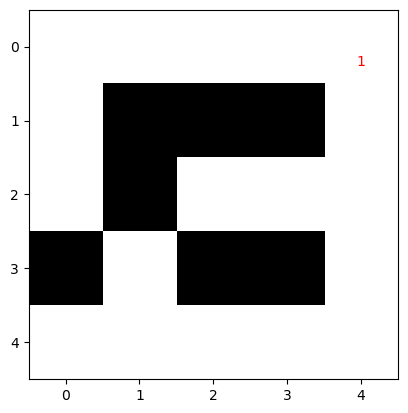

In [40]:
fig = plt.figure()
ani = FuncAnimation(fig, update_plot, frames=max(len(path)
                    for path in new_paths), fargs=(grid, new_paths), interval=3)
ani.save('paths.gif', writer='imagemagick')
plt.show()

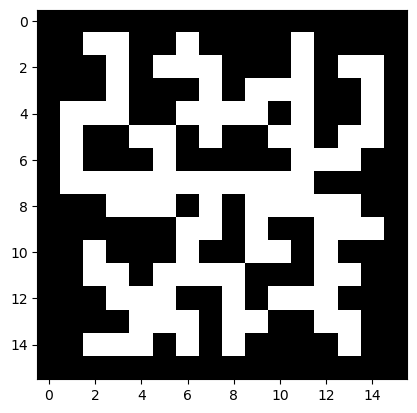

In [41]:
starts = [(7, 8), (10, 12), (4, 2), (9, 7), (7, 1), (4, 3), (7, 4), (9, 6), (1, 2), (4, 1), (7, 7), (6, 1), (8, 7), (5, 1), (3, 3), (4, 14), (2, 3), (1, 3), (7, 2)]

goals = [[(4, 1), (2, 7), (7, 1), (5, 14)], [(13, 13), (8, 5), (5, 11), (11, 5)], [(2, 3), (1, 6), (6, 13), (13, 5)], [(3, 14), (5, 13), (8, 4), (4, 2)], [(1, 2), (8, 4), (3, 10), (1, 3)], [(2, 3), (4, 9), (3, 9), (7, 9)], [(1, 3), (11, 13), (9, 13), (3, 10)], [(10, 10), (4, 2), (6, 11), (12, 5)], [(7, 3), (3, 14), (12, 11), (8, 11)], [(2, 3), (8, 12), (7, 9), (7, 10)], [(11, 8), (2, 11), (5, 5), (12, 5)], [(4, 1), (4, 8), (7, 11), (9, 13)], [(13, 9), (3, 11), (10, 12), (4, 2)], [(4, 2), (7, 1), (11, 5), (7, 3)], [(1, 3), (14, 2), (2, 6), (8, 3)], [(4, 6), (10, 9), (9, 9), (12, 12)], [(1, 3), (10, 12), (8, 12), (5, 5)], [(1, 2), (10, 9), (11, 6), (11, 7)], [(3, 3), (4, 3), (8, 7), (8, 3)]]

grid = np.load("../maps/random_grid_map_1.npy")
plt.imshow(grid, cmap='binary')

In [42]:
paths, priority_order = priority_based_search(grid, starts, goals)

paths = paths.values()

if paths:
    for i, path in enumerate(paths):
        print(f"Agent {i}: {path}")
else:
    print("No solution found")

st_astar: dynamic constraint violated 7 7 1
st_astar: dynamic constraint violated 7 6 2
st_astar: dynamic constraint violated 7 5 3
st_astar: dynamic constraint violated 7 8 1
st_astar: dynamic constraint violated 7 7 1
st_astar: dynamic constraint violated 7 8 1
st_astar: dynamic constraint violated 7 8 2
st_astar: dynamic constraint violated 7 8 2
st_astar: dynamic constraint violated 7 7 1
st_astar: dynamic constraint violated 7 6 2
st_astar: dynamic constraint violated 7 5 3
st_astar: dynamic constraint violated 7 7 1
st_astar: dynamic constraint violated 7 6 3
st_astar: dynamic constraint violated 7 6 2
st_astar: dynamic constraint violated 7 5 3
Agent 0: [(7, 8), (7, 7), (7, 6), (7, 5), (7, 4), (7, 3), (7, 2), (7, 1), (6, 1), (5, 1), (4, 1), (5, 1), (6, 1), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (7, 10), (7, 11), (6, 11), (5, 11), (4, 11), (3, 11), (3, 10), (3, 9), (4, 9), (4, 8), (4, 7), (3, 7), (2, 7), (3, 7), (4, 7), (4, 8), (4, 9), (3, 9), (3,

In [43]:
for i, coords in enumerate(zip(*paths)):
    print(set(coords))
    print(len(set(coords)))

    if i == 4:
        break

# conflicts should be detected at the 4th time step

{(4, 3), (5, 1), (1, 3), (10, 12), (7, 4), (7, 1), (7, 7), (4, 2), (3, 3), (4, 14), (9, 7), (1, 2), (6, 1), (4, 1), (8, 7), (9, 6), (2, 3), (7, 2), (7, 8)}
19
{(4, 3), (5, 1), (10, 6), (1, 3), (7, 4), (7, 1), (7, 7), (4, 2), (3, 3), (9, 7), (6, 1), (7, 3), (4, 1), (8, 7), (5, 14), (9, 6), (11, 12), (2, 3), (7, 2)}
19
{(4, 3), (5, 1), (5, 13), (10, 6), (7, 4), (7, 1), (4, 2), (12, 12), (3, 3), (9, 7), (6, 1), (7, 3), (7, 6), (4, 1), (8, 4), (9, 6), (11, 6), (2, 3), (7, 2)}
19
{(4, 3), (5, 1), (8, 3), (10, 6), (7, 4), (7, 1), (4, 2), (3, 3), (11, 7), (6, 1), (7, 3), (6, 13), (4, 1), (8, 4), (9, 6), (11, 6), (13, 12), (7, 2), (7, 5)}
19
{(6, 12), (7, 4), (7, 1), (4, 3), (6, 1), (5, 1), (4, 2), (7, 3), (13, 13), (11, 6), (8, 3), (3, 3), (10, 6), (7, 2), (4, 1)}
15


CalledProcessError: Command '['convert', '-size', '640x480', '-depth', '8', '-delay', '15.0', '-loop', '0', 'rgba:-', 'paths.gif']' returned non-zero exit status 2.

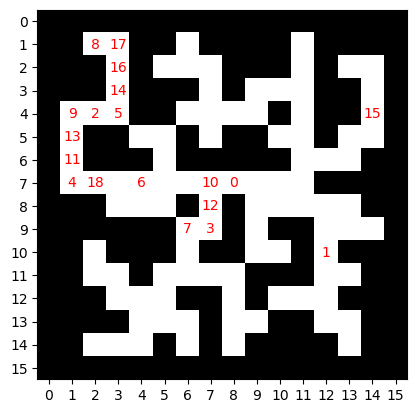

In [6]:
smoothness = 3
new_paths = []
for path in paths:
    new_path = []
    for i in range(len(path)-1):
        new_path.append(path[i])
        for j in range(1, smoothness):
            dir_y = path[i+1][0] - path[i][0]
            dir_x = path[i+1][1] - path[i][1]
            new_c = (path[i][0]+(dir_y/smoothness*j), path[i][1]+(dir_x/smoothness*j))
            new_path.append(new_c)
    new_paths.append(new_path)

fig = plt.figure()
ani = FuncAnimation(fig, update_plot, frames=max(len(path) for path in new_paths), fargs=(grid, new_paths), interval=150)
ani.save('paths.gif', writer='imagemagick')
plt.show()

In [44]:
graph = defaultdict(list)

for agent in range(len(starts)):
    graph[agent] = []

for a, b in priority_order:
    graph[a].append(b)

print(priority_order)

sorted_agents = topological_sort(graph)
print(sorted_agents)

{(6, 18), (8, 14), (9, 13), (0, 10), (8, 17), (3, 7), (4, 6), (3, 10), (4, 18), (13, 11), (14, 5), (5, 2), (17, 16), (8, 16), (12, 3), (8, 5), (2, 9), (0, 18), (16, 14), (11, 4), (9, 4)}
[0, 1, 8, 12, 15, 17, 3, 16, 7, 10, 14, 5, 2, 9, 13, 11, 4, 6, 18]


In [45]:
def prioritized_planning(grid, starts, goals, priorities):
    constraints = []
    paths = [[] for _ in range(len(starts))]

    dynamic_constraints = dict()
    edge_constraints = dict()

    mod_dynamic_constraints = dict()
    mod_edge_constraints = dict()

    for agent in priorities:
        if agent == 6:
            print("hi")
            path = space_time_astar(np.array(grid), starts[agent], goals[agent][:window], mod_dynamic_constraints, edge_constraints)
        else:
            # path = low_level_search(starts[agent], goals[agent], grid, constraints, agent)
            path = space_time_astar(np.array(grid), starts[agent], goals[agent][:window], dynamic_constraints, edge_constraints)

        if path is None:
            return f"agent {agent} No Solution"
        
        mod_path = [(x, y) for (x, y, t) in path]


        print(f"Agent {agent}: {mod_path}")
        paths[agent] = mod_path
    
        for time, pos in enumerate(paths[agent]):
            if time > window:
                break
            # # Add a vertex constraint
            # constraints.append({'type': 'vertex', 'agent': agent, 'pos': pos, 'time': time})
            # # Add an edge constraint (to prevent moving into `a`'s next position)
            # if time < len(paths[agent]) - 1:
            #     edge = (paths[agent][time], paths[agent][time + 1])
            #     constraints.append({'type': 'edge', 'agent': agent, 'edge': edge, 'time': time + 1})

            y, x = pos
            y_2, x_2 = paths[agent][time+1]

            dynamic_constraints[(y, x, time)] = agent
            edge = ((y, x, time), (y_2, x_2, time+1))
            edge_constraints[edge] = agent

            if agent in [4,11,13,9,2,5,14,10,12,0]:
                mod_dynamic_constraints[(y, x, time)] = agent
                mod_edge_constraints[edge] = agent

    return paths


paths = prioritized_planning(grid, starts, goals, sorted_agents)
if type(paths) is list:
    for i, path in enumerate(paths):
        print(f"Agent {i}: {path}")
else:
    print(paths)


Agent 0: [(7, 8), (7, 7), (7, 6), (7, 5), (7, 4), (7, 3), (7, 2), (7, 1), (6, 1), (5, 1), (4, 1), (5, 1), (6, 1), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (7, 10), (7, 11), (6, 11), (5, 11), (4, 11), (3, 11), (3, 10), (3, 9), (4, 9), (4, 8), (4, 7), (3, 7), (2, 7), (3, 7), (4, 7), (4, 8), (4, 9), (3, 9), (3, 10), (3, 11), (4, 11), (5, 11), (6, 11), (7, 11), (7, 10), (7, 9), (7, 8), (7, 7), (7, 6), (7, 5), (7, 4), (7, 3), (7, 2), (7, 1)]
Agent 1: [(10, 12), (11, 12), (12, 12), (13, 12), (13, 13), (13, 12), (12, 12), (11, 12), (10, 12), (9, 12), (8, 12), (8, 11), (8, 10), (8, 9), (7, 9), (7, 8), (7, 7), (7, 6), (7, 5), (8, 5), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (7, 10), (7, 11), (6, 11), (5, 11)]
Agent 8: [(1, 2), (1, 3), (2, 3), (3, 3), (4, 3), (4, 2), (4, 1), (5, 1), (6, 1), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (7, 10), (7, 11), (6, 11), (6, 12), (6, 13), (5, 13), (5, 14), (4, 14), (3, 14), (4, 14), (5, 14), (5, 13)

In [9]:
len([(7, 4), (7, 4), (8, 4), (8, 3), (7, 3), (7, 2), (7, 1), (6, 1), (5, 1), (4, 1), (4, 2), (4, 3), (3, 3), (2, 3), (1, 3), (2, 3), (3, 3), (4, 3), (4, 2), (4, 1), (5, 1), (6, 1), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (7, 10), (7, 11), (8, 11), (8, 12), (9, 12), (10, 12), (11, 12), (11, 13), (11, 12), (10, 12), (9, 12), (9, 13)]), len([(7, 4), (7, 3), (8, 3), (8, 3), (7, 3), (7, 2), (7, 1), (6, 1), (5, 1), (4, 1), (4, 2), (4, 3), (3, 3), (2, 3), (1, 3), (2, 3), (3, 3), (4, 3), (4, 2), (4, 1), (5, 1), (6, 1), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (7, 10), (7, 11), (8, 11), (8, 12), (9, 12), (10, 12), (11, 12), (11, 13), (11, 12), (10, 12), (9, 12), (9, 13)]
)


(43, 43)

In [14]:
len([(8, 7), (7, 7), (7, 6), (7, 6), (7, 7), (7, 8), (7, 9), (7, 10), (7, 11), (6, 11), (6, 12), (6, 13), (5, 13), (5, 14), (5, 13), (6, 13), (6, 12), (6, 11), (7, 11), (7, 10), (7, 9), (7, 8), (7, 7), (8, 7), (9, 7), (9, 6), (10, 6), (11, 6), (10, 6), (9, 6), (9, 7), (8, 7), (7, 7), (7, 6), (7, 5), (7, 4), (7, 3), (7, 2), (7, 1), (6, 1), (5, 1), (4, 1), (4, 2), (4, 3), (3, 3), (2, 3)])

46

In [ ]:
# PP
for time, pos in enumerate(paths[agent]):
        if time > window:
            break
        # # Add a vertex constraint
        # constraints.append({'type': 'vertex', 'agent': agent, 'pos': pos, 'time': time})
        # # Add an edge constraint (to prevent moving into `a`'s next position)
        # if time < len(paths[agent]) - 1:
        #     edge = (paths[agent][time], paths[agent][time + 1])
        #     constraints.append({'type': 'edge', 'agent': agent, 'edge': edge, 'time': time + 1})

        y, x = pos
        y_2, x_2 = paths[agent][time+1]

        dynamic_constraints[(y, x, time)] = agent
        edge = ((y, x, time), (y_2, x_2, time+1))
        edge_constraints[edge] = agent



# PBS
for t, pos in enumerate(higher_agent_path):
    if t > window:
        break

    y, x = pos
    y_2, x_2 = higher_agent_path[t+1]

    dynamic_constraints[(y, x, t)] = higher_agent
    # add edge constraints (only add the first window elements)
    edge = ((y, x, t), (y_2, x_2, t+1))
    edge_constraints[edge] = higher_agent



    
for y, x, t in path:
    if t > window:
        break
    
    dynamic_constraints[(y, x, t)] = agent
# add edge constraints (only add the first window elements)
for t, pos in enumerate(path):
    if t > window:
        break
    edge = ((path[t][0], path[t][1], path[t][2]), (path[t+1][0], path[t+1][1], path[t+1][2]))
    edge_constraints[edge] = agent

In [16]:
list(zip([(7, 4), (7, 4), (8, 4), (8, 3), (7, 3), (7, 2), (7, 1), (6, 1), (5, 1), (4, 1), (4, 2), (4, 3), (3, 3), (2, 3), (1, 3), (2, 3), (3, 3), (4, 3), (4, 2), (4, 1), (5, 1), (6, 1), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (7, 10), (7, 11), (8, 11), (8, 12), (9, 12), (10, 12), (11, 12), (11, 13), (11, 12), (10, 12), (9, 12), (9, 13)], 
[(7, 8), (7, 7), (7, 6), (7, 5), (7, 4), (7, 3), (7, 2), (7, 1), (6, 1), (5, 1), (4, 1), (5, 1), (6, 1), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (7, 10), (7, 11), (6, 11), (5, 11), (4, 11), (3, 11), (3, 10), (3, 9), (4, 9), (4, 8), (4, 7), (3, 7), (2, 7), (3, 7), (4, 7), (4, 8), (4, 9), (3, 9), (3, 10), (3, 11), (4, 11), (5, 11), (6, 11), (7, 11), (7, 10), (7, 9), (7, 8), (7, 7), (7, 6), (7, 5), (7, 4), (7, 3), (7, 2), (7, 1)]))

[((7, 4), (7, 8)),
 ((7, 4), (7, 7)),
 ((8, 4), (7, 6)),
 ((8, 3), (7, 5)),
 ((7, 3), (7, 4)),
 ((7, 2), (7, 3)),
 ((7, 1), (7, 2)),
 ((6, 1), (7, 1)),
 ((5, 1), (6, 1)),
 ((4, 1), (5, 1)),
 ((4, 2), (4, 1)),
 ((4, 3), (5, 1)),
 ((3, 3), (6, 1)),
 ((2, 3), (7, 1)),
 ((1, 3), (7, 2)),
 ((2, 3), (7, 3)),
 ((3, 3), (7, 4)),
 ((4, 3), (7, 5)),
 ((4, 2), (7, 6)),
 ((4, 1), (7, 7)),
 ((5, 1), (7, 8)),
 ((6, 1), (7, 9)),
 ((7, 1), (7, 10)),
 ((7, 2), (7, 11)),
 ((7, 3), (6, 11)),
 ((7, 4), (5, 11)),
 ((7, 5), (4, 11)),
 ((7, 6), (3, 11)),
 ((7, 7), (3, 10)),
 ((7, 8), (3, 9)),
 ((7, 9), (4, 9)),
 ((7, 10), (4, 8)),
 ((7, 11), (4, 7)),
 ((8, 11), (3, 7)),
 ((8, 12), (2, 7)),
 ((9, 12), (3, 7)),
 ((10, 12), (4, 7)),
 ((11, 12), (4, 8)),
 ((11, 13), (4, 9)),
 ((11, 12), (3, 9)),
 ((10, 12), (3, 10)),
 ((9, 12), (3, 11)),
 ((9, 13), (4, 11))]